In [1]:
from __future__ import print_function
import glob
import clip
from itertools import chain
import os
import cv2
import random
# import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
# from functools import reduce
import torch.nn as nn
# from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from PIL import Image
from imgaug import augmenters as iaa
# from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from skimage import io, img_as_float
import timm
from torchvision.transforms import ToPILImage
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import csv
import numpy as np
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, precision_recall_curve

In [2]:
# Local imports
from utils import class_labels, get_dataset, get_transforms, DeepFakeSet, get_class_based_training_data
from models import clipmodel, dinov2, CLIPModelOhja
from trainer import train_model
# from os import path
# import sys
# sys.path.append(path.abspath('./beit/'))
# from beit.getBEIT import createBEIT, load_model

In [3]:
device = 'cuda'

In [4]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
# dataset_name = 'progan'
# num_images_from_each_class = 0
# all_training_images, all_validation_images = get_dataset(dataset_name, num_images_from_each_class, balance_classes=False)

dataset_name = 'progan'
num_images_from_each_class = 500
# balance_classes will be set to True if we need subset of images, lets say if we need 250 image from each class for shorter training
all_training_images, all_validation_images = get_dataset(dataset_name, num_images_from_each_class, balance_classes=True)

# class_name_list = ['airplane']
# all_training_images, all_validation_images = get_class_based_training_data(class_name_list, all_training_images, all_validation_images)

In [6]:
print(f"Training Data: {len(all_training_images)}")
print('***********************************')
print('***********************************')
print(f"Validation Data: {len(all_validation_images)}")

Training Data: 10000
***********************************
***********************************
Validation Data: 2000


In [7]:
# count = 0
# for i in range(len(all_training_images)):
#     if 'bus' in all_training_images[i]:
#         if 'n01440764' in all_training_images[i]:
#             count+=1

In [8]:
# count = 0
# for i in range(len(all_training_images)):
#     if 'n01440764' in all_training_images[i]:
#         count+=1
# count

In [9]:
# np.random.shuffle(all_training_images)

In [10]:
labels = [path.split('/')[-2].split('_')[-1] for path in all_training_images]
print(labels[:10])

['n01440764', 'n01443537', 'n01443537', 'n01443537', 'n01440764', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01440764']


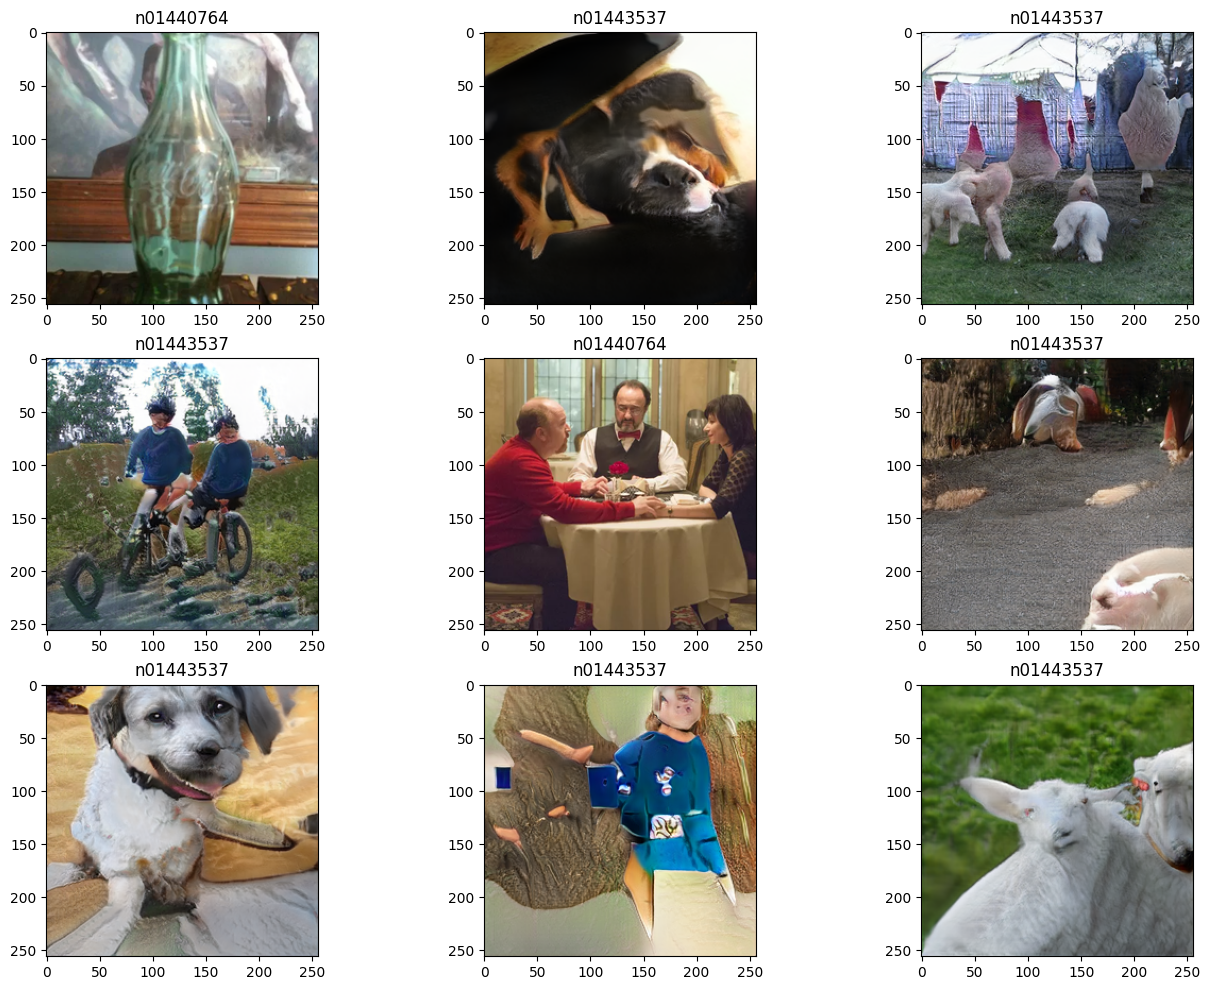

In [11]:
random_idx = np.random.randint(1, len(all_training_images), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
#     frames = sorted(glob.glob(train_list[idx] +'/*.png'))
#     frame = frames[0]
    img = Image.open(all_training_images[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [12]:
train_transforms, val_transforms, clip_train_transforms, clip_val_transforms, test_transforms = get_transforms()

In [13]:
train_data = DeepFakeSet(all_training_images, transform=clip_train_transforms)
valid_data = DeepFakeSet(all_validation_images, transform=clip_val_transforms)

batch_size = 16

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

10000 625
2000 125


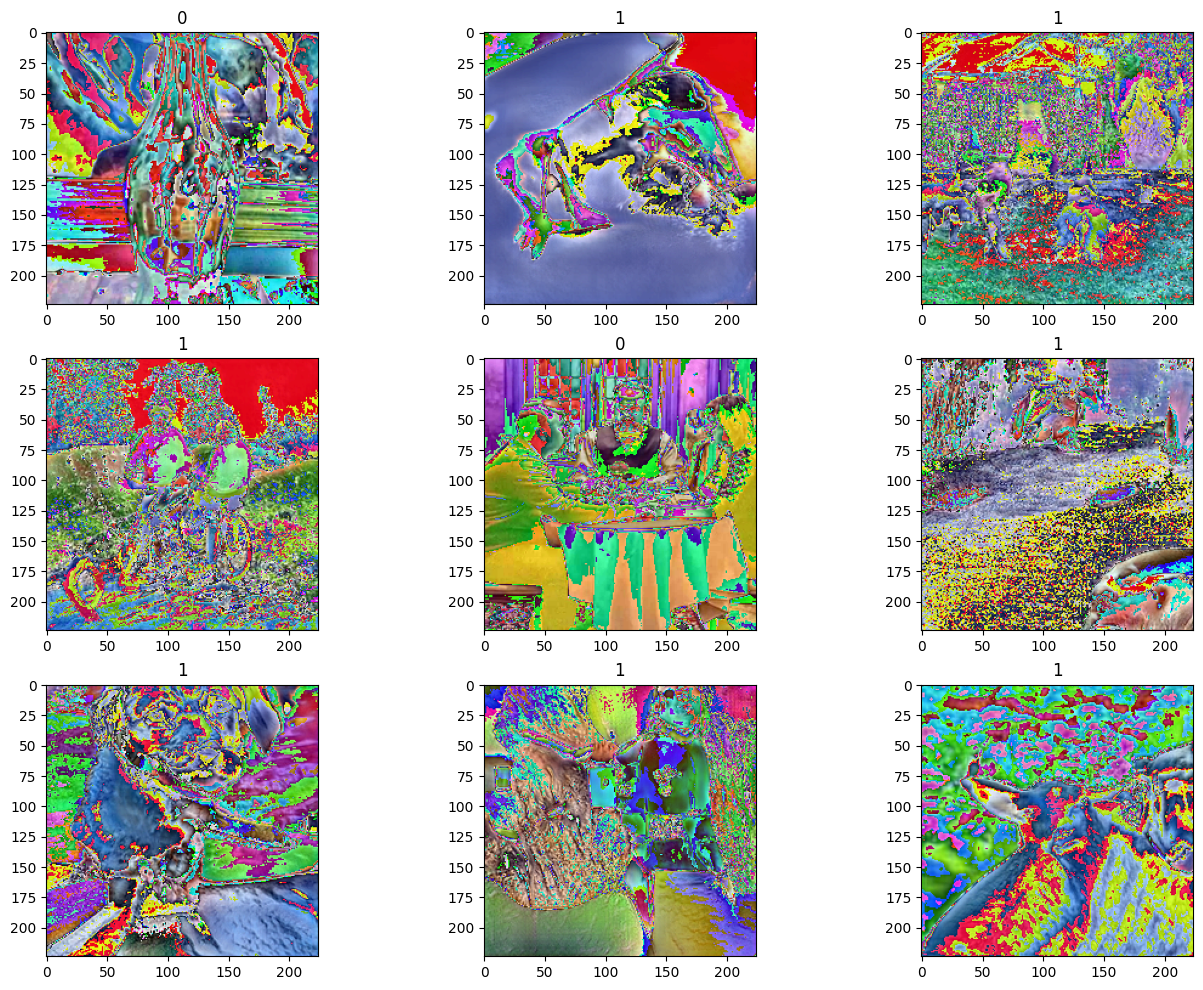

In [14]:
to_img = ToPILImage()
random_idx = np.random.randint(1, len(train_data), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = (to_img(train_data[idx][0]))
    ax.set_title(train_data[idx][1])
    ax.imshow(img)

In [15]:
# model = CLIPModelOhja()
model = clipmodel()
model.to(device)

clipmodel(
  (feature_extractor): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDyn

In [16]:
epochs = 2
lr = 3e-3
# gamma = 0.7
warmup_epochs = 1

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5)
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
# Warm-up epoch with a different learning rate
warmup_optimizer = optim.SGD(model.parameters(), lr=0.0001)

model.train()
for epoch in range(epochs):
    if epoch < warmup_epochs:
        optimizer = warmup_optimizer
    else:
        optimizer = optimizer
    epoch_loss = 0
    epoch_accuracy = 0

    # Keep track of intermediate statistics for every 5 batches
    running_loss = 0.0
    running_accuracy = 0.0
    print_every = 10
    
    for batch_idx, (data, label) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        running_accuracy += acc
        running_loss += loss.item()

        # Print accuracy and loss after every 5 processed batches
        if (batch_idx + 1) % print_every == 0:
            avg_running_accuracy = running_accuracy / print_every
            avg_running_loss = running_loss / print_every
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(train_loader)}, Loss: {avg_running_loss:.4f}, Acc: {avg_running_accuracy:.4f}')
            running_accuracy = 0.0
            running_loss = 0.0

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)
#             print(data.shape)aa
            with torch.cuda.amp.autocast():
                val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    torch.cuda.empty_cache()
    
# torch.save(trained_model.state_dict(), model_name + '_linear_prob_5_epochs_vit_large.pth')

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1, Batch 10/625, Loss: 0.7639, Acc: 0.4062
Epoch 1, Batch 20/625, Loss: 0.7457, Acc: 0.5000
Epoch 1, Batch 30/625, Loss: 0.7311, Acc: 0.4750
Epoch 1, Batch 40/625, Loss: 0.7095, Acc: 0.5125
Epoch 1, Batch 50/625, Loss: 0.7261, Acc: 0.5000
Epoch 1, Batch 60/625, Loss: 0.7327, Acc: 0.4563
Epoch 1, Batch 70/625, Loss: 0.6998, Acc: 0.5563
Epoch 1, Batch 80/625, Loss: 0.6743, Acc: 0.6125
Epoch 1, Batch 90/625, Loss: 0.6913, Acc: 0.5688
Epoch 1, Batch 100/625, Loss: 0.6896, Acc: 0.5500
Epoch 1, Batch 110/625, Loss: 0.6683, Acc: 0.6250
Epoch 1, Batch 120/625, Loss: 0.6375, Acc: 0.7063
Epoch 1, Batch 130/625, Loss: 0.6553, Acc: 0.6000
Epoch 1, Batch 140/625, Loss: 0.6666, Acc: 0.6062
Epoch 1, Batch 150/625, Loss: 0.6596, Acc: 0.5688
Epoch 1, Batch 160/625, Loss: 0.6448, Acc: 0.6500
Epoch 1, Batch 170/625, Loss: 0.6284, Acc: 0.6438
Epoch 1, Batch 180/625, Loss: 0.6083, Acc: 0.7500
Epoch 1, Batch 190/625, Loss: 0.6226, Acc: 0.7000
Epoch 1, Batch 200/625, Loss: 0.6249, Acc: 0.6687
Epoch 1, 

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.5625 - acc: 0.7526 - val_loss : 0.5889 - val_acc: 0.7365



  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2, Batch 10/625, Loss: 0.4588, Acc: 0.8875
Epoch 2, Batch 20/625, Loss: 0.4397, Acc: 0.9062
Epoch 2, Batch 30/625, Loss: 0.4430, Acc: 0.9000
Epoch 2, Batch 40/625, Loss: 0.4353, Acc: 0.9313
Epoch 2, Batch 50/625, Loss: 0.4134, Acc: 0.9500
Epoch 2, Batch 60/625, Loss: 0.4185, Acc: 0.9125
Epoch 2, Batch 70/625, Loss: 0.4068, Acc: 0.9438
Epoch 2, Batch 80/625, Loss: 0.4282, Acc: 0.9062
Epoch 2, Batch 90/625, Loss: 0.4076, Acc: 0.9375
Epoch 2, Batch 100/625, Loss: 0.4116, Acc: 0.9313
Epoch 2, Batch 110/625, Loss: 0.4176, Acc: 0.9125
Epoch 2, Batch 120/625, Loss: 0.4014, Acc: 0.9187
Epoch 2, Batch 130/625, Loss: 0.3968, Acc: 0.9250
Epoch 2, Batch 140/625, Loss: 0.3763, Acc: 0.9563
Epoch 2, Batch 150/625, Loss: 0.4007, Acc: 0.9250
Epoch 2, Batch 160/625, Loss: 0.3916, Acc: 0.9250
Epoch 2, Batch 170/625, Loss: 0.3718, Acc: 0.9187
Epoch 2, Batch 180/625, Loss: 0.3868, Acc: 0.9313
Epoch 2, Batch 190/625, Loss: 0.3742, Acc: 0.9563
Epoch 2, Batch 200/625, Loss: 0.3823, Acc: 0.9313
Epoch 2, 

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.3638 - acc: 0.9379 - val_loss : 0.5483 - val_acc: 0.7630



In [21]:
# torch.save(model.state_dict(), 'finetuned_2_epochs_clip_base.pth')
# torch.save(model.state_dict(), 'linear_prob_2_epochs_clip_base.pth')
# torch.save(model.state_dict(), 'progan_layer_norm_tuning_linear_prob_2_epochs_clip_large.pth')
# torch.save(model.state_dict(), 'sd_200k_linear_prob_2_epochs_clip_large.pth')
# torch.save(model.state_dict(), 'sd_200k_linear_prob_2_epochs_dinov2_large.pth')

In [7]:
model.fc.load_state_dict(torch.load('fc_weights.pth'), strict=True)
model.eval()
model.cuda()


CLIPModelOhja(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamically

## Weight Ensembling

In [22]:
finetuned = clipmodel()

In [42]:
finetuned.load_state_dict(torch.load('finetuned_2_epochs_clip_base.pth'), strict=False)


<All keys matched successfully>

In [24]:
import torch
import clip
from PIL import Image

# device = "cuda" if torch.cuda.is_available() else "cpu"
zeroshot , preprocess = clip.load("ViT-B/16")

In [25]:
theta_0 = zeroshot.state_dict()
theta_1 = finetuned.state_dict()

print(len(theta_0.keys()))
print(len(theta_1.keys()))

# linear_bias = theta_1.popitem()
# linear_weight = theta_1.popitem()

# print(len(theta_0.keys()))
# print(len(theta_1.keys()))

302
304


In [26]:
new_theta_0 = {}
prefix = 'feature_extractor'
for key, value in theta_0.items():
    new_key = f'{prefix}.{key}'
    new_theta_0[new_key] = value

In [27]:
# # make sure checkpoints are compatible
# # assert set(new_theta_0.keys()) == set(theta_1.keys())

# alpha = 0.5
# # interpolate between checkpoints with mixing coefficient alpha
# theta = {
#     key: (1-alpha) * new_theta_0[key] + alpha * theta_1[key]
#     for key in new_theta_0.keys()
# }
# theta

In [28]:
theta = {}
alpha = 0.5  # Adjust the alpha value as needed

try:
    for key, value_1 in theta_1.items():
        try:
            value_0 = new_theta_0[key]
            theta[key] = (1 - alpha) * value_0 + alpha * value_1
        except KeyError:
            print(f"Key '{key}' not found in new_theta_0. Appending from theta_1.")
            theta[key] = value_1

except Exception as e:
    print(f"An unexpected error occurred: {e}")
    # You can add additional error-handling code or raise the exception again if needed

# # Now, append remaining keys from theta_1 to theta
# for key, value_1 in theta_1.items():
#     if key not in theta:
#         theta[key] = value_1

print(theta)


Key 'classifier.linear.weight' not found in new_theta_0. Appending from theta_1.
Key 'classifier.linear.bias' not found in new_theta_0. Appending from theta_1.
{'feature_extractor.positional_embedding': tensor([[-2.1005e-04, -8.2970e-05, -4.0588e-03,  ...,  4.8399e-04,
          2.7828e-03,  4.6120e-03],
        [ 2.0275e-03, -2.3651e-03, -9.2602e-04,  ...,  2.6760e-03,
          7.5769e-04,  1.6463e-04],
        [-1.7824e-03,  1.0462e-03, -7.0429e-04,  ...,  7.2765e-04,
          2.5616e-03,  4.2772e-04],
        ...,
        [ 1.8418e-04,  1.3990e-03, -8.9169e-05,  ..., -3.0842e-03,
         -4.8714e-03,  3.6583e-03],
        [-5.9547e-03,  3.7498e-03,  8.8043e-03,  ..., -1.3647e-03,
         -3.8471e-03,  6.4735e-03],
        [ 5.6343e-03, -1.7273e-02, -1.5312e-02,  ..., -6.6376e-03,
          5.5733e-03, -1.8555e-02]], device='cuda:0'), 'feature_extractor.text_projection': tensor([[-0.0087,  0.0040, -0.0137,  ...,  0.0086, -0.0194, -0.0168],
        [-0.0014,  0.0102,  0.0042,  ...

In [96]:
linear_weight

('classifier.linear.weight',
 tensor([[-0.0048, -0.0144, -0.0315,  ..., -0.0083,  0.0151, -0.0078],
         [-0.0091, -0.0008,  0.0229,  ...,  0.0142,  0.0161,  0.0132]]))

In [29]:
# Assuming 'theta' is the resulting dictionary
theta_state_dict_path = 'theta_state_dict.pth'

# Save the 'theta' dictionary as a PyTorch state dictionary
torch.save(theta, theta_state_dict_path)

In [30]:
finetuned.load_state_dict(torch.load('theta_state_dict.pth'), strict=True)


<All keys matched successfully>

In [31]:
# theta_1 = finetuned.state_dict()
# theta_1

# Evaluate

In [8]:
# finetuned.eval()
# finetuned.cuda()
# print('==')

In [17]:

labels_map = ["real", "fake"]
count = 0
all_images = []
predicted_labels = []
true_labels = []
predicted_probs = []

images = sorted(glob.glob('../Datasets/ICMRDataset/test/PreviousPaperTestSet/laion/0_real/*.jpg'))
fake_images = sorted(glob.glob('../Datasets/ICMRDataset/test/PreviousPaperTestSet/glide_100_27/1_fake/*.png'))

# images = sorted(glob.glob('../CoOp/data/ImageNet/images/val/n01440764/*.jpg'))
# fake_images = sorted(glob.glob('../CoOp/data/ImageNet/images/val/n01443537/*.jpg'))

print(len(images))
print(len(fake_images))

# np.random.shuffle(fake_images)
# np.random.shuffle(fake_images)

all_images = images
all_images.extend(fake_images)

all_images = [path.replace('\\','/') for path in all_images]
y_pred = []
for image in all_images:
    img = cv2.imread(image)
    img = cv2_jpg(img, 50)
    # image = add_noise(image, 0.4)
    img = Image.fromarray(img)
    img = img.convert('RGB')
    # img = Image.open(image)
    tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                               transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
                              ])
    img = tfms(img)
    y_true = []
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = model(img.unsqueeze(0).to(device))
            y_pred.extend(outputs.sigmoid().flatten().tolist())
            # y_true.extend(label.flatten().tolist())

    # for idx in torch.topk(outputs[0], k=1).indices.tolist():
    #     prob = torch.softmax(outputs[0], 0)[idx].item()
    #     if labels_map[idx] == 'real':
    #         print("real")
    #         predicted_labels.append(0)
    #         predicted_probs.append(1 - prob)
    #     else:
    #         print("fake")
    #         predicted_labels.append(1)
    #         predicted_probs.append(prob)
    
    print(outputs.sigmoid().flatten())
    if outputs.sigmoid().flatten() < 0.5:
        print("real")
        predicted_labels.append(0)
        predicted_probs.append(outputs.sigmoid().flatten().cpu().numpy())
    else:
        print("fake")
        predicted_labels.append(1)
        predicted_probs.append(outputs.sigmoid().flatten().cpu().numpy())
    
    print(image.split('/')[-2])
    if 'real' in image.split('/')[-2]:
        true_labels.append(0)
    else:
        true_labels.append(1)
    print('--------------')

y_true, y_pred = np.array(true_labels), np.array(y_pred)
# train with compression and blur

1000
1000
tensor([0.0034], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.0303], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.0003], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([2.0325e-05], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.0002], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.0031], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.0003], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.0587], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([3.4571e-06], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.0003], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.1251], device='cuda:0', dtype=torch.float16)
real
0_real
--------------
tensor([0.0104], device='cuda:0', dtype=torch.float16)
real
0_real
-------------

In [21]:
len(predicted_probs)

2000

In [22]:
average_precision_score(true_labels, predicted_probs)

0.9377544116706268

In [23]:
accuracy_score(true_labels, predicted_labels)

0.8265

In [14]:
average_precision_score(true_labels, predicted_probs)

0.9114970773088925

In [15]:
accuracy_score(true_labels, predicted_labels)

0.829